In [ ]:
! pip install rdkit

In [ ]:
! pip install chembl_webresource_client

In [ ]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np  # numpy digunakan untuk operasi array
# Pastikan juga RDKit diimpor dengan benar jika belum
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Pencarian target untuk interferon gamma menggunakan chembl_webresource_client
target = new_client.target
target_query = target.search('interferon gamma')
targets = pd.DataFrame.from_dict(target_query)
targets


In [ ]:
# Cari baris di DataFrame yang memiliki target_chembl_id 'CHEMBL3267'
selected_target_row = targets[targets.target_chembl_id == 'CHEMBL3267']

# Jika baris ditemukan, ambil target_chembl_id, jika tidak, beri peringatan
if not selected_target_row.empty:
    selected_target = selected_target_row.iloc[0]['target_chembl_id']
else:
    print("Target CHEMBL3267 tidak ditemukan.")
    raise ValueError("Target CHEMBL3267 tidak ditemukan.")

print("Selected target:", selected_target)

# Lakukan pencarian aktivitas untuk target yang dipilih dengan tipe standar 'IC50'
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)

print(df.shape)
df.head()

In [40]:
# Menghapus baris yang memiliki nilai tidak valid pada kolom 'standard_value' dan 'canonical_smiles' langsung pada df
df.dropna(subset=['standard_value', 'canonical_smiles'], inplace=True)
df.drop_duplicates(subset=['canonical_smiles'], inplace=True)

# Menampilkan 5 baris teratas dari df setelah modifikasi
print(df.shape)
df.head(2)


(3468, 46)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,1734327,[],CHEMBL871582,Inhibition of human PI3Kgamma,B,NaN,NaN,BAO_0000190,...,Homo sapiens,PI3-kinase p110-gamma subunit,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,30.0
1,NaN,NaN,1734356,[],CHEMBL871582,Inhibition of human PI3Kgamma,B,NaN,NaN,BAO_0000190,...,Homo sapiens,PI3-kinase p110-gamma subunit,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,5.0


In [41]:
# Memilih hanya kolom-kolom tertentu ('molecule_chembl_id', 'canonical_smiles', 'standard_value')
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
df = df.loc[:, selection]

# Menampilkan df setelah modifikasi
print(df.shape)
df.head(2)

(3468, 3)


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL379156,O=C1NC(=O)/C(=C/c2ccc(-c3ccc(F)cc3O)o2)S1,30.0
1,CHEMBL428496,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,5.0


In [42]:
# Menetapkan batas bioaktivitas (IC50) dan menambahkan kolom 'class' untuk kategori bioaktivitas
df['class'] = df['standard_value'].apply(lambda x: 'inactive' if float(x) >= 10000 else ('active' if float(x) <= 1000 else 'intermediate'))
# Menampilkan df setelah modifikasi
print(df.shape)
df.head(2)

(3468, 4)


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL379156,O=C1NC(=O)/C(=C/c2ccc(-c3ccc(F)cc3O)o2)S1,30.0,active
1,CHEMBL428496,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,5.0,active


In [43]:
def lipinski(smiles, verbose=False):
    # Menggunakan list comprehension untuk membuat objek molekul RDKit
    moldata = [Chem.MolFromSmiles(elem) for elem in smiles]

    # Menghitung deskriptor Lipinski menggunakan list comprehension
    baseData = np.array([[
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol)
    ] for mol in moldata if mol is not None])

    # Membuat DataFrame dari data deskriptor
    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors

# Menghitung deskriptor Lipinski untuk senyawa kimia yang sudah dibersihkan SMILES-nya
df_lipinski = lipinski(df['canonical_smiles'])
# Menampilkan df lipinski
print(df_lipinski.shape)
df_lipinski.head(2)


(3468, 4)


,MW,LogP,NumHDonors,NumHAcceptors
0,305.286,3.1152,2.0,5.0
1,428.437,2.5364,0.0,8.0


In [44]:
# Pastikan indeks dari kedua DataFrame sesuai sebelum menggabungkan
if not df.index.equals(df_lipinski.index):
    df.reset_index(drop=True, inplace=True)
    df_lipinski.reset_index(drop=True, inplace=True)

# Menggabungkan DataFrame df dengan df_lipinski
df_combined = pd.concat([df, df_lipinski], axis=1)

# Menampilkan df_combined
print(df_combined.shape)
df_combined.head(2)


(3468, 8)


,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL379156,O=C1NC(=O)/C(=C/c2ccc(-c3ccc(F)cc3O)o2)S1,30.0,active,305.286,3.1152,2.0,5.0
1,CHEMBL428496,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,5.0,active,428.437,2.5364,0.0,8.0


In [45]:
# Normalisasi nilai 'standard_value'
def norm_value(input_df):
    norm = []
    for i in input_df['standard_value']:
        numeric_value = float(i)
        if numeric_value > 100000000:
            numeric_value = 100000000
        norm.append(numeric_value)

    input_df['standard_value_norm'] = norm
    return input_df.drop('standard_value', axis=1)


In [46]:
# Normalisasi nilai 'standard_value' pada DataFrame df_combined
df = norm_value(df_combined)

# Menampilkan df_combined
print(df.shape)
df.head(2)

(3468, 8)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL379156,O=C1NC(=O)/C(=C/c2ccc(-c3ccc(F)cc3O)o2)S1,active,305.286,3.1152,2.0,5.0,30.0
1,CHEMBL428496,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,active,428.437,2.5364,0.0,8.0,5.0


In [47]:
def pIC50(input):
    # Menghitung pIC50 menggunakan list comprehension dan menyimpannya langsung ke dalam kolom baru 'pIC50'
    input['pIC50'] = [-np.log10(i * (10**-9)) for i in input['standard_value_norm']]

    # Menghapus kolom 'standard_value_norm' dan mengembalikan DataFrame yang dimodifikasi
    return input.drop('standard_value_norm', axis=1)

    # Mengonversi nilai 'standard_value_norm' menjadi pIC50 dan menampilkan statistik deskriptif
df = pIC50(df)

print(df.shape)
df.head(2)


(3468, 8)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL379156,O=C1NC(=O)/C(=C/c2ccc(-c3ccc(F)cc3O)o2)S1,active,305.286,3.1152,2.0,5.0,7.522879
1,CHEMBL428496,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,active,428.437,2.5364,0.0,8.0,8.301030


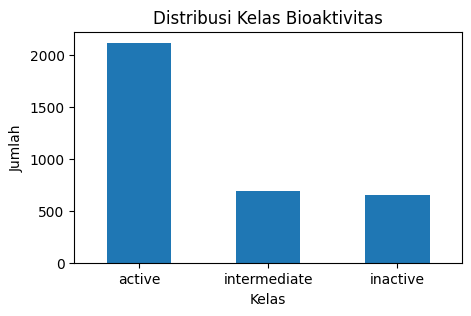

In [48]:
import matplotlib.pyplot as plt

# Menghitung jumlah kejadian untuk setiap kelas
class_counts = df['class'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(5, 3))
class_counts.plot(kind='bar')
plt.title('Distribusi Kelas Bioaktivitas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

In [49]:
print(df.shape)
df = df[df['class'] != 'intermediate']

(3468, 8)


In [ ]:
! pip install wget

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
! unzip padel.zip

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! bash padel.sh

In [50]:
df_X = pd.read_csv("descriptors_output.csv")
print(df_X.shape)
df_X.head()

(2777, 882)


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL379156,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL377337,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL428496,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL437688,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL209159,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df_X.drop(columns = ['Name'], axis = 1, inplace = True)
X = df_X.astype(float)

X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2773,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2774,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2775,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
y = df['class']
y = y.map({'active' : 1, 'inactive' : 0 })

y

0       1
1       1
3       1
5       1
6       1
       ..
3463    1
3464    1
3465    1
3466    1
3467    1
Name: class, Length: 2777, dtype: int64

In [53]:
y.value_counts()

class
1    2122
0     655
Name: count, dtype: int64

In [54]:
from imblearn.over_sampling import SMOTE


smote = SMOTE( random_state=42)
X_smote, y_smote = smote.fit_resample(X.astype(float), y)

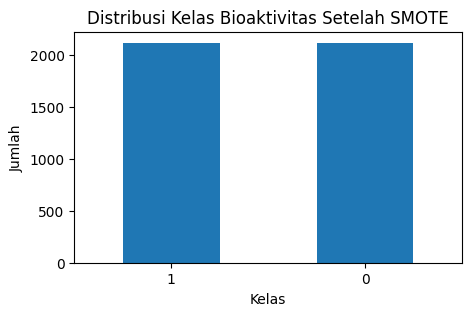

In [55]:
import matplotlib.pyplot as plt

# Menghitung jumlah kejadian untuk setiap kelas setelah resampling
class_counts = pd.Series(y_smote).value_counts()

# Membuat diagram batang
plt.figure(figsize=(5, 3))
class_counts.plot(kind='bar')
plt.title('Distribusi Kelas Bioaktivitas Setelah SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state = 123, stratify=y_smote)

In [57]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3183, 881) (1061, 881)
(3183,) (1061,)


In [ ]:
! pip install catboost

In [58]:
import catboost as cb
from sklearn.metrics import accuracy_score

final_model = cb.CatBoostClassifier(
    objective="CrossEntropy",
    colsample_bylevel=0.01589,
    depth=6,
    boosting_type="Plain",
    bootstrap_type="Bernoulli",
    subsample=0.35347,
    learning_rate=0.13,
    iterations=4000,
    eval_metric="Accuracy",
    used_ram_limit="3gb",
    random_state=42,
    verbose=0
)

# Melatih model dengan parameter baru
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100  # Menggunakan early stopping
)

# Evaluasi model
preds_train = final_model.predict(X_train)
accuracy_train = accuracy_score(y_train, preds_train)
preds_valid = final_model.predict(X_test)
accuracy_valid = accuracy_score(y_test, preds_valid)

print("Akurasi model pada data pelatihan:", accuracy_train)
print("Akurasi model pada data validasi:", accuracy_valid)


Akurasi model pada data pelatihan: 0.981464027646874
Akurasi model pada data validasi: 0.9349670122525919


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, preds_valid)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Classification Report
print(classification_report(y_test, preds_valid))

# ROC Curve dan AUC Score
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, preds_valid):.2f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Dapatkan probabilitas prediksi untuk kelas positif
probs_pos = final_model.predict_proba(X_test)[:, 1]

# Hitung nilai true probabilities dan predicted probabilities
true_prob, predicted_prob = calibration_curve(y_test, probs_pos, n_bins=10, strategy='uniform')

# Membuat plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(predicted_prob, true_prob, 's-', label='Model CatBoost')

# Plot garis sempurna sebagai referensi
plt.plot([0, 1], [0, 1], 'k--', label='Sempurna Kalibrasi')

plt.title('Calibration Curve')
plt.xlabel('Probabilitas Prediksi')
plt.ylabel('Frekuensi Kelas Positif Sebenarnya')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Misalkan 'final_model' adalah model yang sudah dilatih
# Kami akan mengkalibrasinya dengan isotonic regression
calibrated = CalibratedClassifierCV(final_model, method='isotonic', cv='prefit')

# Fit the calibrated model
calibrated.fit(X_test, y_test)

# Sekarang, model 'calibrated' dapat memberikan probabilitas yang lebih terkalibrasi
calibrated_probs = calibrated.predict_proba(X_test)[:, 1]

true_prob, predicted_prob = calibration_curve(y_test, calibrated_probs, n_bins=10, strategy='uniform')

# Plot calibration curve yang terkalibrasi
plt.figure(figsize=(8, 6))
plt.plot(predicted_prob, true_prob, 's-', label='Model CatBoost Terkalibrasi')
plt.plot([0, 1], [0, 1], 'k--', label='Sempurna Kalibrasi')
plt.title('Calibration Curve')
plt.xlabel('Probabilitas Prediksi')
plt.ylabel('Frekuensi Kelas Positif Sebenarnya')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import brier_score_loss


# Mendapatkan label sebenarnya dari dataset uji
y_true = y_test

# Sekarang Anda dapat menghitung Brier Score atau metrik evaluasi lainnya
brier_score = brier_score_loss(y_true, calibrated_probs)
print("Brier Score:", brier_score)

In [ ]:
# Menghitung Brier Score untuk probabilitas yang belum dikalibrasi
brier_score_uncaled = brier_score_loss(y_true, probs_pos)
print("Brier Score untuk probabilitas yang belum dikalibrasi:", brier_score_uncaled)

# Menghitung Brier Score untuk probabilitas yang telah dikalibrasi
brier_score_calibrated = brier_score_loss(y_true, calibrated_probs)
print("Brier Score untuk probabilitas yang telah dikalibrasi:", brier_score_calibrated)

# Membandingkan kedua Brier Score
print("\nPerbandingan Brier Score:")
print("Tidak Dikalibrasi vs Dikalibrasi: {:.4f} vs {:.4f}".format(brier_score_uncaled, brier_score_calibrated))

In [ ]:
# Menyusun DataFrame untuk membandingkan nilai aktual, prediksi, dan probabilitas.
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Prediction': preds_valid,
    'Probability': probs_pos
})

comparison_df

In [ ]:
# Menyusun DataFrame untuk membandingkan nilai aktual, prediksi, dan probabilitas.
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Prediction': preds_valid,
    'Probability': calibrated_probs
})

comparison_df